In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
!unzip /content/chest-xray-masks-and-labels.zip -d /content/kaggle/

100% 9.56G/9.58G [01:59<00:00, 110MB/s]
100% 9.58G/9.58G [02:00<00:00, 85.7MB/s]
Archive:  /content/chest-xray-masks-and-labels.zip
  inflating: /content/kaggle/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: /content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: /content/

In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as TorchDataset
from torchvision import transforms
from typing import List, Tuple

class CustomDataset(TorchDataset):
    """
    Custom dataset for loading image and mask pairs from directories.

    Args:
        image_dir (str): Directory containing images.
        mask_dir (str): Directory containing masks.
        dataset_type (str): 'train' or 'val/test' to specify the split.
        split_ratio (float): Split ratio for train/val/test.
        transform (callable, optional): Transform to be applied to both image and mask.
    """

    def __init__(
        self,
        image_dir: str,
        mask_dir: str,
        dataset_type: str = "train",
        split_ratio: float = 0.2,
        transform: callable = None
    ):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.masks = os.listdir(mask_dir)

        if dataset_type == "train":
            split_index = int(len(self.masks) * (1 - split_ratio))
            self.masks = self.masks[:split_index]
        else:
            split_index = int(len(self.masks) * (1 - split_ratio))
            self.masks = self.masks[split_index:]

    def __len__(self) -> int:
        return len(self.masks)

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        img_path = os.path.join(self.image_dir, self.masks[index].replace("_mask.png", ".png"))

        try:
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
            mask[mask == 255.0] = 1.0
        except Exception as e:
            raise Exception(f"Error loading image/mask at index {index}: {str(e)}")

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

    def plot_sample(self, index: int):
        """
        Plot a sample image and its corresponding mask.

        Args:
            index (int): Index of the sample to plot.
        """
        image, mask = self.__getitem__(index)

        # Converte o tensor de imagem para um array NumPy e ajusta o formato
        image_numpy = image.permute(1, 2, 0).cpu().numpy()

        # Converte o tensor de máscara para um array NumPy e ajusta o formato
        mask_numpy = mask.cpu().numpy()

        # Converte a máscara para uma imagem binária
        mask_image = Image.fromarray((mask_numpy * 255).astype(np.uint8))

        # Plotagem da imagem original
        plt.subplot(1, 2, 1)
        plt.imshow(image_numpy)
        plt.title("Image")

        # Plotagem da máscara
        plt.subplot(1, 2, 2)
        plt.imshow(mask_image, cmap="gray")
        plt.title("Mask")

        plt.tight_layout()
        plt.show()




In [7]:
import torch.nn as nn
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm

class UNet(nn.Module):
    """
    Implementação da arquitetura UNet para segmentação de imagens.

    Args:
        n_classes (int): Número de classes a serem segmentadas.
    """

    def __init__(self, n_classes, in_channels=3, num_filters=64):
        """
        Inicializa a rede UNet.

        Args:
            n_classes (int): Número de classes a serem segmentadas.
            in_channels (int): Número de canais da imagem de entrada (default: 3 para imagens coloridas RGB).
            num_filters (int): Número de filtros iniciais (default: 64).
        """
        super().__init__()
        self.n_classes = n_classes
        self.in_channels = in_channels
        self.num_filters = num_filters
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Camadas de convolução descendentes (Encoder)
        self.conv_down1 = self.double_conv(in_channels, num_filters)
        self.conv_down2 = self.double_conv(num_filters, num_filters * 2)
        self.conv_down3 = self.double_conv(num_filters * 2, num_filters * 4)
        self.conv_down4 = self.double_conv(num_filters * 4, num_filters * 8)

        self.maxpool = nn.MaxPool2d(2)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Camadas de convolução ascendentes (Decoder)
        self.conv_up3 = self.double_conv(num_filters * (4 + 8), num_filters * 4)
        self.conv_up2 = self.double_conv(num_filters * (2 + 4), num_filters * 2)
        self.conv_up1 = self.double_conv(num_filters * (2 + 1), num_filters)

        # Última camada de convolução para ajustar o número de classes
        self.last_conv = nn.Conv2d(num_filters, self.n_classes, kernel_size=1)

    def forward(self, x):
        """
        Realiza uma passagem para a frente na rede UNet.

        Args:
            x (torch.Tensor): Tensor de entrada com as imagens.

        Returns:
            torch.Tensor: Tensor de saída com as máscaras segmentadas.
        """
        # Convoluções descendentes e Max pooling
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)

        x = self.upsample(x)

        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv_up1(x)

        out = self.last_conv(x)
        out = torch.sigmoid(out)

        return out

    def double_conv(self, in_channels, out_channels):
        """
        Define uma sequência de duas camadas de convolução seguidas por ativações ReLU.

        Args:
            in_channels (int): Número de canais de entrada.
            out_channels (int): Número de canais de saída.

        Returns:
            nn.Sequential: Sequência de camadas de convolução e ativações.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def train_model(self, num_epochs, train_loader, learning_rate=0.001, weight_decay=1e-3):
        """
        Treina o modelo UNet com os dados de treinamento e calcula as métricas IoU e Dice.

        Args:
            num_epochs (int): Número de épocas de treinamento.
            train_loader (torch.utils.data.DataLoader): DataLoader com os dados de treinamento.
            learning_rate (float): Taxa de aprendizado (default: 0.001).
            weight_decay (float): Peso da regularização L2 (default: 1e-3).
        """

        optimizer = torch.optim.Adamax(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        criterion = nn.BCELoss()

        self.to(self.device)

        for epoch in range(num_epochs):
            self.train()
            total_loss = 0.0
            total_correct = 0
            total_samples = 0
            total_iou = 0.0
            total_dice = 0.0

            for batch in tqdm(train_loader):
                inputs, labels = batch[0].to(self.device), batch[1].to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)

                labels = labels.unsqueeze(1)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                predicted = (outputs > 0.5).float()
                correct = (predicted == labels).sum().item()
                total_correct += correct
                total_samples += labels.numel()

                # Calcular a métrica IoU
                intersection = (predicted * labels).sum().item()
                union = (predicted + labels).sum().item() - intersection
                iou = intersection / union
                total_iou += iou

                # Calcular a métrica Dice
                dice = (2 * intersection) / (predicted.sum().item() + labels.sum().item())
                total_dice += dice

            average_loss = total_loss / len(train_loader)
            accuracy = total_correct / total_samples
            average_iou = total_iou / len(train_loader)
            average_dice = total_dice / len(train_loader)

            print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f} - IoU: {average_iou:.4f} - Dice: {average_dice:.4f}')

    def predict_image(self, image_path):
        """
        Predição de uma máscara.

        Args:
            image_path (str): Path to the input image.

        Returns:
            torch.Tensor: Predicted mask as a tensor.
        """
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224), Image.ANTIALIAS)

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        image = transform(image)

        image = image.unsqueeze(0).to(self.device)

        with torch.no_grad():
            predicted_mask = self(image)

        return predicted_mask

    def save_model(self, filepath):
        """
        Salva o modelo treinado em um arquivo.

        Args:
            filepath (str): Caminho para o arquivo onde o modelo será salvo.
        """
        checkpoint = {
            'state_dict': self.state_dict(),
            'n_classes': self.n_classes,
            'in_channels': self.in_channels,
            'num_filters': self.num_filters
        }
        torch.save(checkpoint, filepath)
        print(f'Model saved to {filepath}')

    @classmethod
    def load_model(cls, filepath, device='cuda'):
        """
        Carrega um modelo previamente salvo a partir de um arquivo.

        Args:
            filepath (str): Caminho para o arquivo onde o modelo foi salvo.
            device (str): Dispositivo onde o modelo será carregado (default: 'cuda').

        Returns:
            UNet: Instância do modelo carregado.
        """
        checkpoint = torch.load(filepath, map_location=device)
        model = cls(n_classes=checkpoint['n_classes'], in_channels=checkpoint['in_channels'], num_filters=checkpoint['num_filters'])
        model.load_state_dict(checkpoint['state_dict'])
        print(f'Model loaded from {filepath}')
        return model


100%|██████████| 36/36 [01:48<00:00,  3.00s/it]


Epoch [1/3] - Loss: 0.5431 - Accuracy: 0.7436 - IoU: 0.0000 - Dice: 0.0000


100%|██████████| 36/36 [01:45<00:00,  2.94s/it]


Epoch [2/3] - Loss: 0.4131 - Accuracy: 0.7768 - IoU: 0.2136 - Dice: 0.2819


100%|██████████| 36/36 [01:46<00:00,  2.96s/it]
<ipython-input-7-eee35ea94314>:171: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((224, 224), Image.ANTIALIAS)


Epoch [3/3] - Loss: 0.2976 - Accuracy: 0.8761 - IoU: 0.5913 - Dice: 0.7393


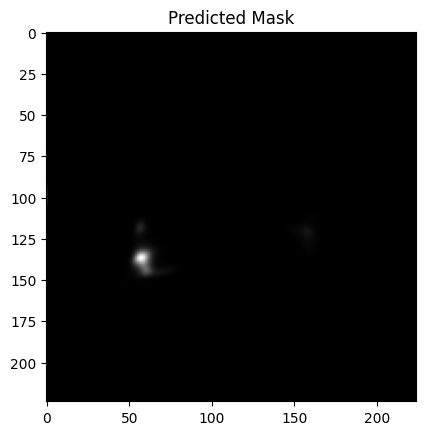

In [12]:
from torch.utils.data import DataLoader
# from dataset import CustomDataset
# from u_net import UNet
# from resnet_unet import ResNeXtUNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt



def get_loaders(image_dir, mask_dir, batch_size, train_transform, val_transform, num_workers=2, pin_memory=True):

    train_ds = CustomDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        dataset_type="train",
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CustomDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        dataset_type="test",
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

img_h, img_w = 224, 224

train_transform = A.Compose(
        [
            A.Resize(height=img_h, width=img_w),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=img_h, width=img_w),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

img_dir = '/content/kaggle/Lung Segmentation/CXR_png'
mask_dir = '/content/kaggle/Lung Segmentation/masks'
batch_size = 16
pin_mem = True
workers = 2

train_loader, val_loader = get_loaders(img_dir, mask_dir, batch_size, train_transform, val_transforms, workers, pin_mem)

model = UNet(n_classes=1)
model.train_model(num_epochs=3, train_loader=train_loader, learning_rate=0.001, weight_decay=1e-3)
predicted_mask = model.predict_image("/content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0002_0.png")
plt.imshow(predicted_mask[0, 0].cpu().numpy(), cmap="gray")
plt.title("Predicted Mask")
plt.show()

In [13]:
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch
from torchvision.models.resnet import resnext50_32x4d
import torch.nn.functional as F

class ResNeXtUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.base_model = resnext50_32x4d(weights=True)
        self.base_layers = list(self.base_model.children())
        filters = [4 * 64, 4 * 128, 4 * 256, 4 * 512]

        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        self.decoder4 = self.decoder_block(filters[3], filters[2])
        self.decoder3 = self.decoder_block(filters[2], filters[1])
        self.decoder2 = self.decoder_block(filters[1], filters[0])
        self.decoder1 = self.decoder_block(filters[0], filters[0])

        self.last_conv0 = self.conv_relu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        out = self.last_conv0(d1)
        out = self.last_conv1(out)

        out = torch.sigmoid(out)

        return out

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            self.conv_relu(in_channels, in_channels // 4, 1, 0),
            nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4, stride=2, padding=1, output_padding=0),
            self.conv_relu(in_channels // 4, out_channels, 1, 0)
        )

    def conv_relu(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(inplace=True)
        )

    def train_model(self, num_epochs, train_loader, learning_rate=0.001, weight_decay=1e-3):
        optimizer = torch.optim.Adamax(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        criterion = nn.BCELoss()

        self.to(self.device)  # Mova o modelo para o dispositivo disponível

        for epoch in range(num_epochs):
            total_loss = 0.0  # Inicializa a perda total para esta época
            correct_predictions = 0
            total_samples = 0

            for batch in tqdm(train_loader):
                inputs, labels = batch[0].to(self.device), batch[1].to(self.device)

                # Antes de passar os rótulos pelo modelo, expanda a dimensão do canal para corresponder à saída do modelo
                labels = labels.unsqueeze(1)

                optimizer.zero_grad()

                outputs = self(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Calcule a acurácia
                predicted_labels = (outputs > 0.5).float()  # Converta as previsões em rótulos binários
                correct_predictions += (predicted_labels == labels).sum().item()
                total_samples += labels.numel()

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples  # Acurácia calculada como proporção de previsões corretas

            print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}')

    def predict_image(self, image_path):
        """
        Predição de uma máscara.

        Args:
            image_path (str): Path to the input image.

        Returns:
            torch.Tensor: Predicted mask as a tensor.
        """
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224), Image.ANTIALIAS)

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        image = transform(image)

        image = image.unsqueeze(0).to(self.device)

        with torch.no_grad():
            predicted_mask = self(image)

        return predicted_mask

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 119MB/s]
100%|██████████| 36/36 [01:48<00:00,  3.01s/it]


Epoch [1/3] - Loss: 0.4106 - Accuracy: 0.7853


100%|██████████| 36/36 [01:44<00:00,  2.91s/it]


Epoch [2/3] - Loss: 0.1064 - Accuracy: 0.9644


100%|██████████| 36/36 [01:43<00:00,  2.89s/it]
<ipython-input-13-6df2eaa54be0>:112: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((224, 224), Image.ANTIALIAS)


Epoch [3/3] - Loss: 0.0719 - Accuracy: 0.9738


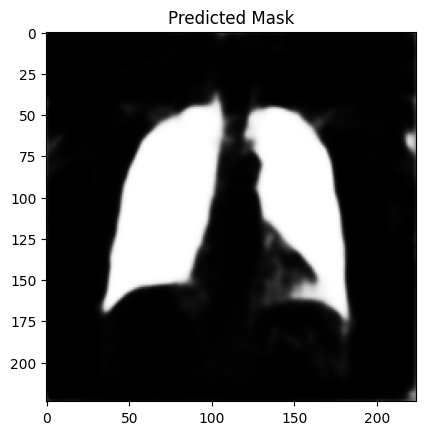

In [14]:
img_dir = '/content/kaggle/Lung Segmentation/CXR_png'
mask_dir = '/content/kaggle/Lung Segmentation/masks'
batch_size = 16
pin_mem = True
workers = 2

train_loader, val_loader = get_loaders(img_dir, mask_dir, batch_size, train_transform, val_transforms, workers, pin_mem)

model = ResNeXtUNet(n_classes=1)
model.train_model(num_epochs=3, train_loader=train_loader, learning_rate=0.001, weight_decay=1e-3)
predicted_mask = model.predict_image("/content/kaggle/Lung Segmentation/CXR_png/CHNCXR_0008_0.png")
plt.imshow(predicted_mask[0, 0].cpu().numpy(), cmap="gray")
plt.title("Predicted Mask")
plt.show()